# Quantum Walks

A classical random walk is a mathematical model used to describe a path consisting of a succession of random steps. In a one-dimensional random walk, a walker moves along a line, taking steps of fixed length either to the right or to the left. The direction of each step is determined by a random process, such as flipping a coin. Each step to the right or left has an equal probability of 0.5 in a symmetric random walk.

A quantum walk is a quantum analog of a classical random walk, which describes the movement of a particle that moves step by step in a random manner, in this case through the flipping of a coin. Such types of quantum walks are known as Discrete-Time Quantum Walks.

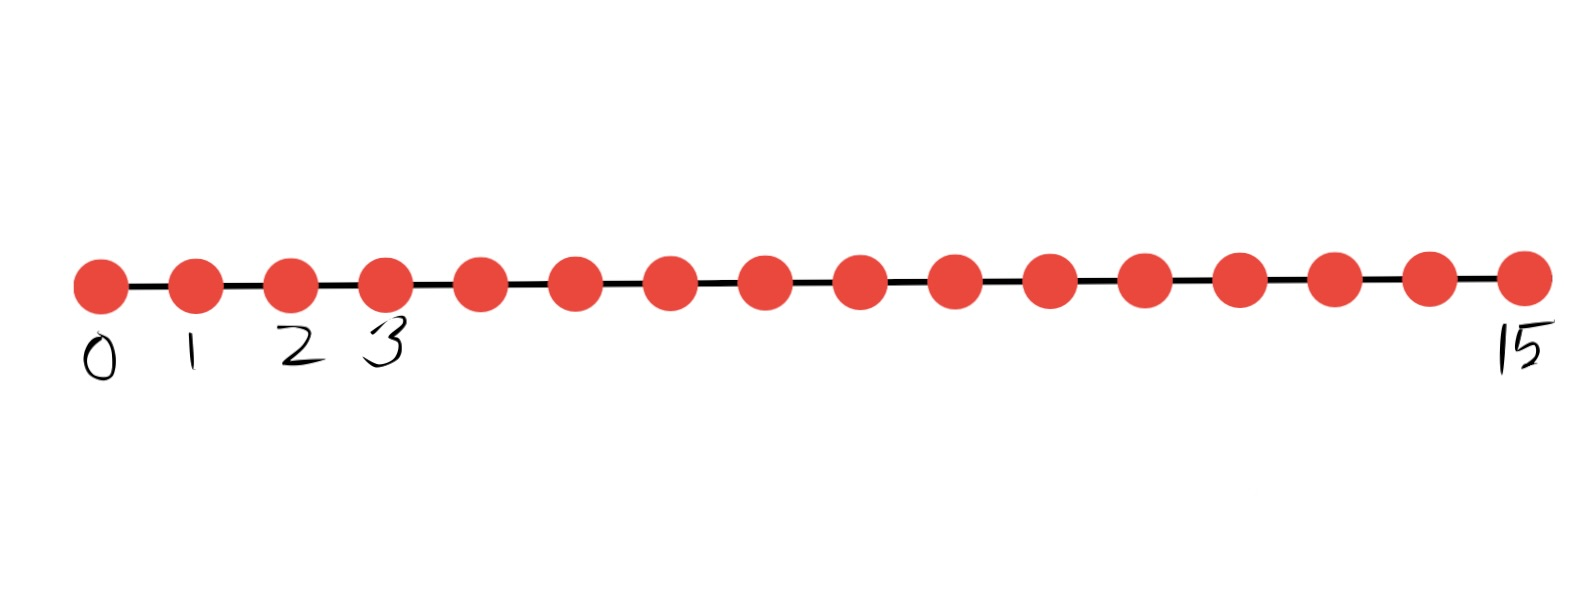

#### Discrete-Time Quantum Walk (DTQW):

In a discrete-time quantum walk, the particle moves in discrete steps based on a coin flip operation and a shift operation.
The coin operation puts the particle into a superposition of states, and the shift operation moves the particle based on the coin's outcome.
When we looked into the code of the circle with 4 vertices, we could see an example that was built on a graph. Here we are going to explore quantum walk operator on a line with 16 nodes.

## Project Objective:

We have to design a quantum walk operator for the case of a line with 16 nodes numbered from 0 to 15. Each of these nodes are placed one after the other in succession such that, other than the extreme ends each node has two neighbouring nodes.

We need to set the number of qubits allocated to 4, so that we have 16 nodes numbered from 0 to 15. It is calculated by the formula $2^{n}>=16$. Designing the quantum walk operator for a line with 16 nodes involves creating both the coin (C) and shift (S) operators.

In [117]:
from classiq import *

##### Coin Operator:

After determining movement probabilities through the coin operator we apply the shift operator. In this case we also have to keep in mind the two extreme nodes 0 and 15 wherein the probability is 1 (when we consider node 0, only option of shifting is to node 1 and when we consider node 15, only option of shifting is to node 14). While for all the nodes in the middle, we have equal probabilities of going to the right or to the left.

In [121]:
size=4 #number of qubits required for 16 nodes
nodes=2**size

#prepares the |-> state
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
    
    
def coin_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*nodes  
    if i == 0:
        prob[i + 1] = 1.0 
    elif i == nodes - 1:
        prob[i - 1] = 1.0 
    else:
        prob[i - 1] = 0.5 
        prob[i + 1] = 0.5  
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def coin_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(nodes):
      coin_iteration(i,vertices,adjacent_vertices)

##### Shift Operator:

In a quantum walk on a line with 16 nodes, the shift operator is crucial because it determines how the walker moves left or right based on the state of the coin qubit.
For each position x depending upon the coin state the shift operator moves (swaps the states) of the walker from position x to x+1 or from position x to x−1.

In [111]:
#checks whether two vertices are adjacent or not
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

#applies shift operator to change the position of the two vertices (nodes in this case)
@qfunc 
def shift_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

##### Quantum Walk Main Function:

We do not know which node would be chosen in the beginning. Thus, we need to ensure an equal superposition of all the nodes present in the walk. This can be done using the Hadamard Gate which, we know, ensures equal superposition of basis states for each node.

In [115]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  coin_operator(vertices,adjacent_vertices) #coin operator
  shift_operator(vertices,adjacent_vertices) #shift operator

# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

We can see a pattern obtained in the probability vector amplitudes of the given nodes. It is quite similar to the classical coin flipping function, which can be seen in the graph below. 

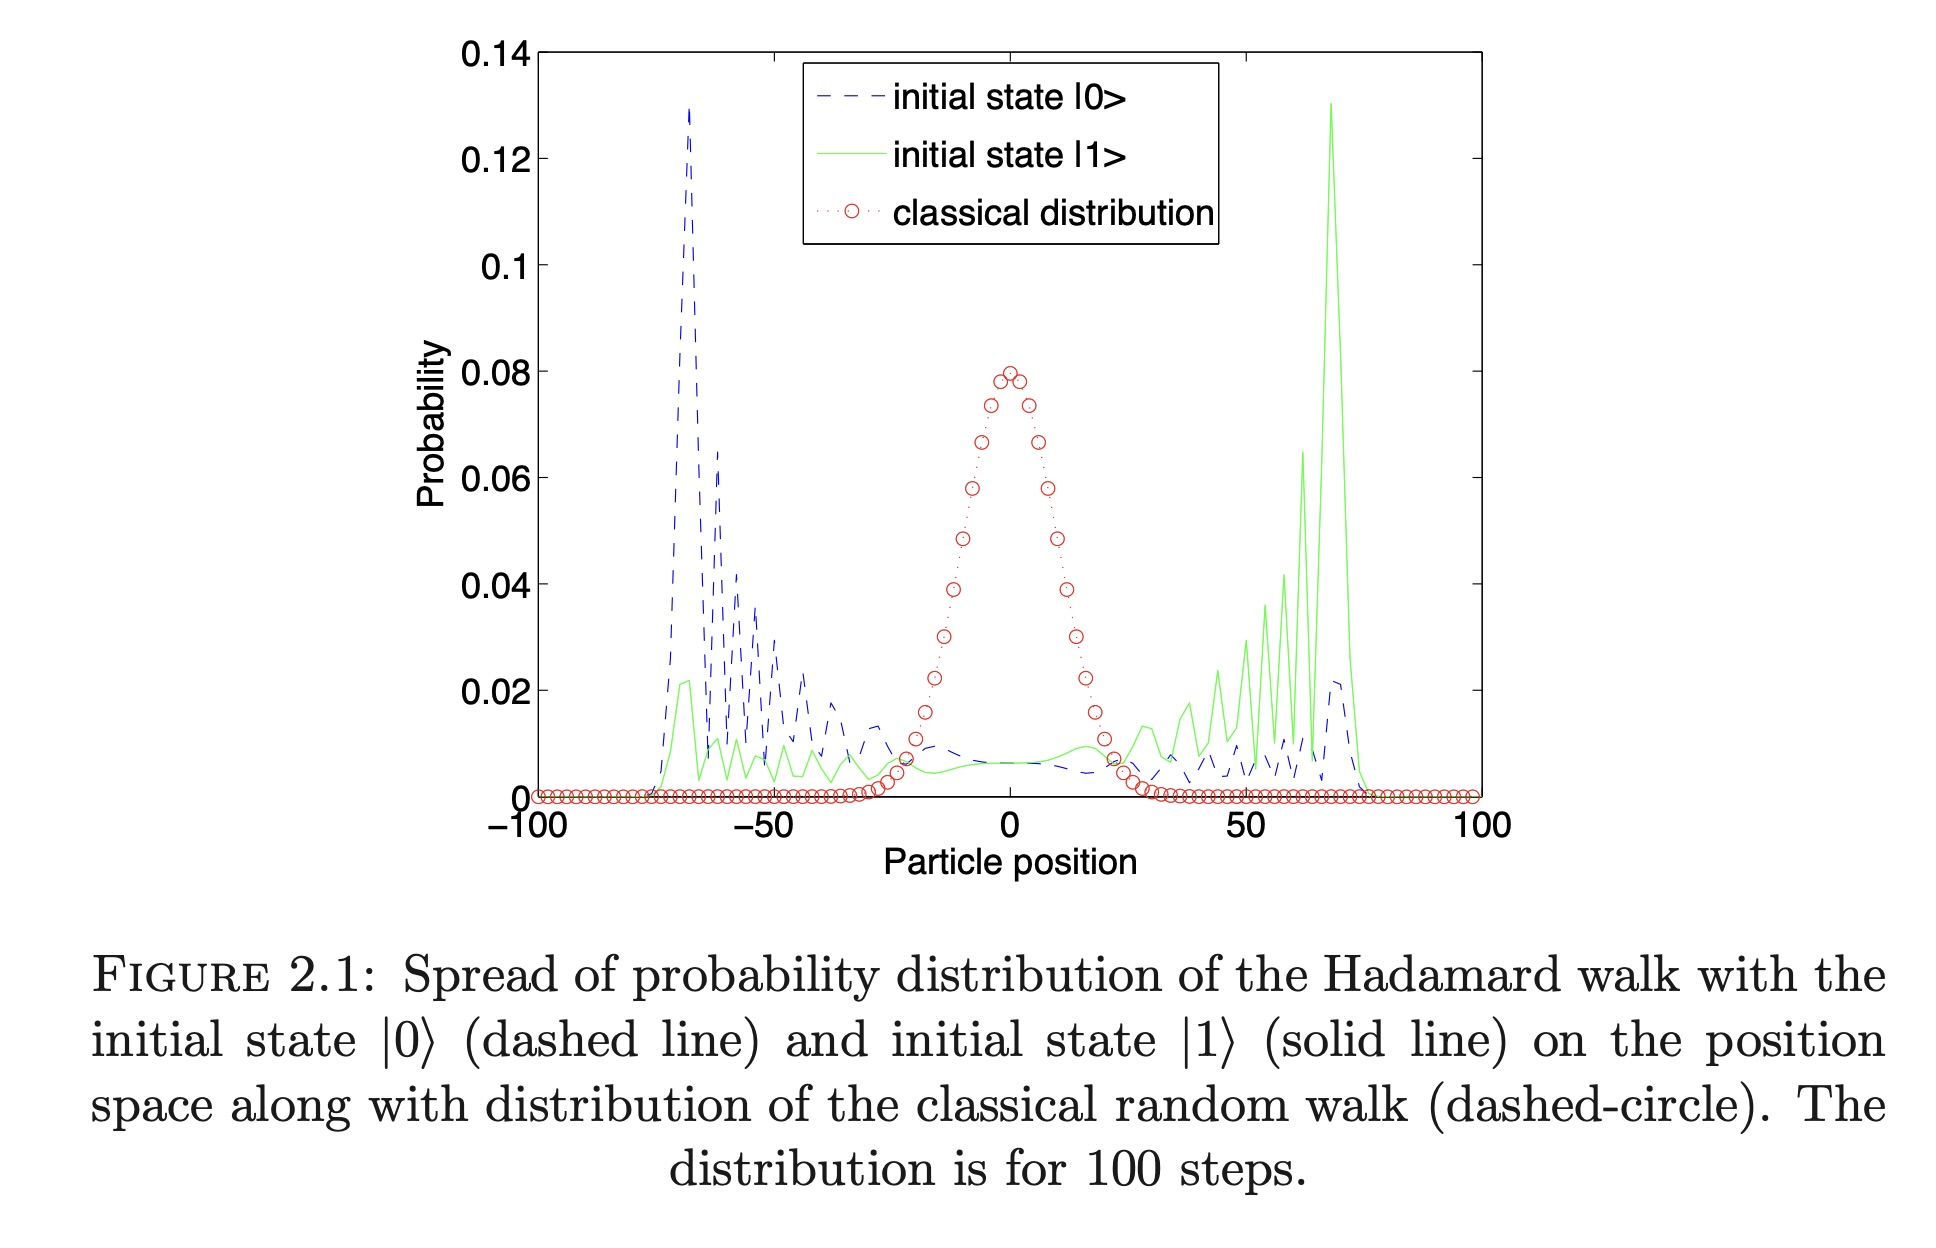

_Picture reference: https://arxiv.org/pdf/1001.5326 - Discrete Time Quantum Walk - Dynamics and Applications by C. M. Chandrashekhar_

## Circuit Diagram:

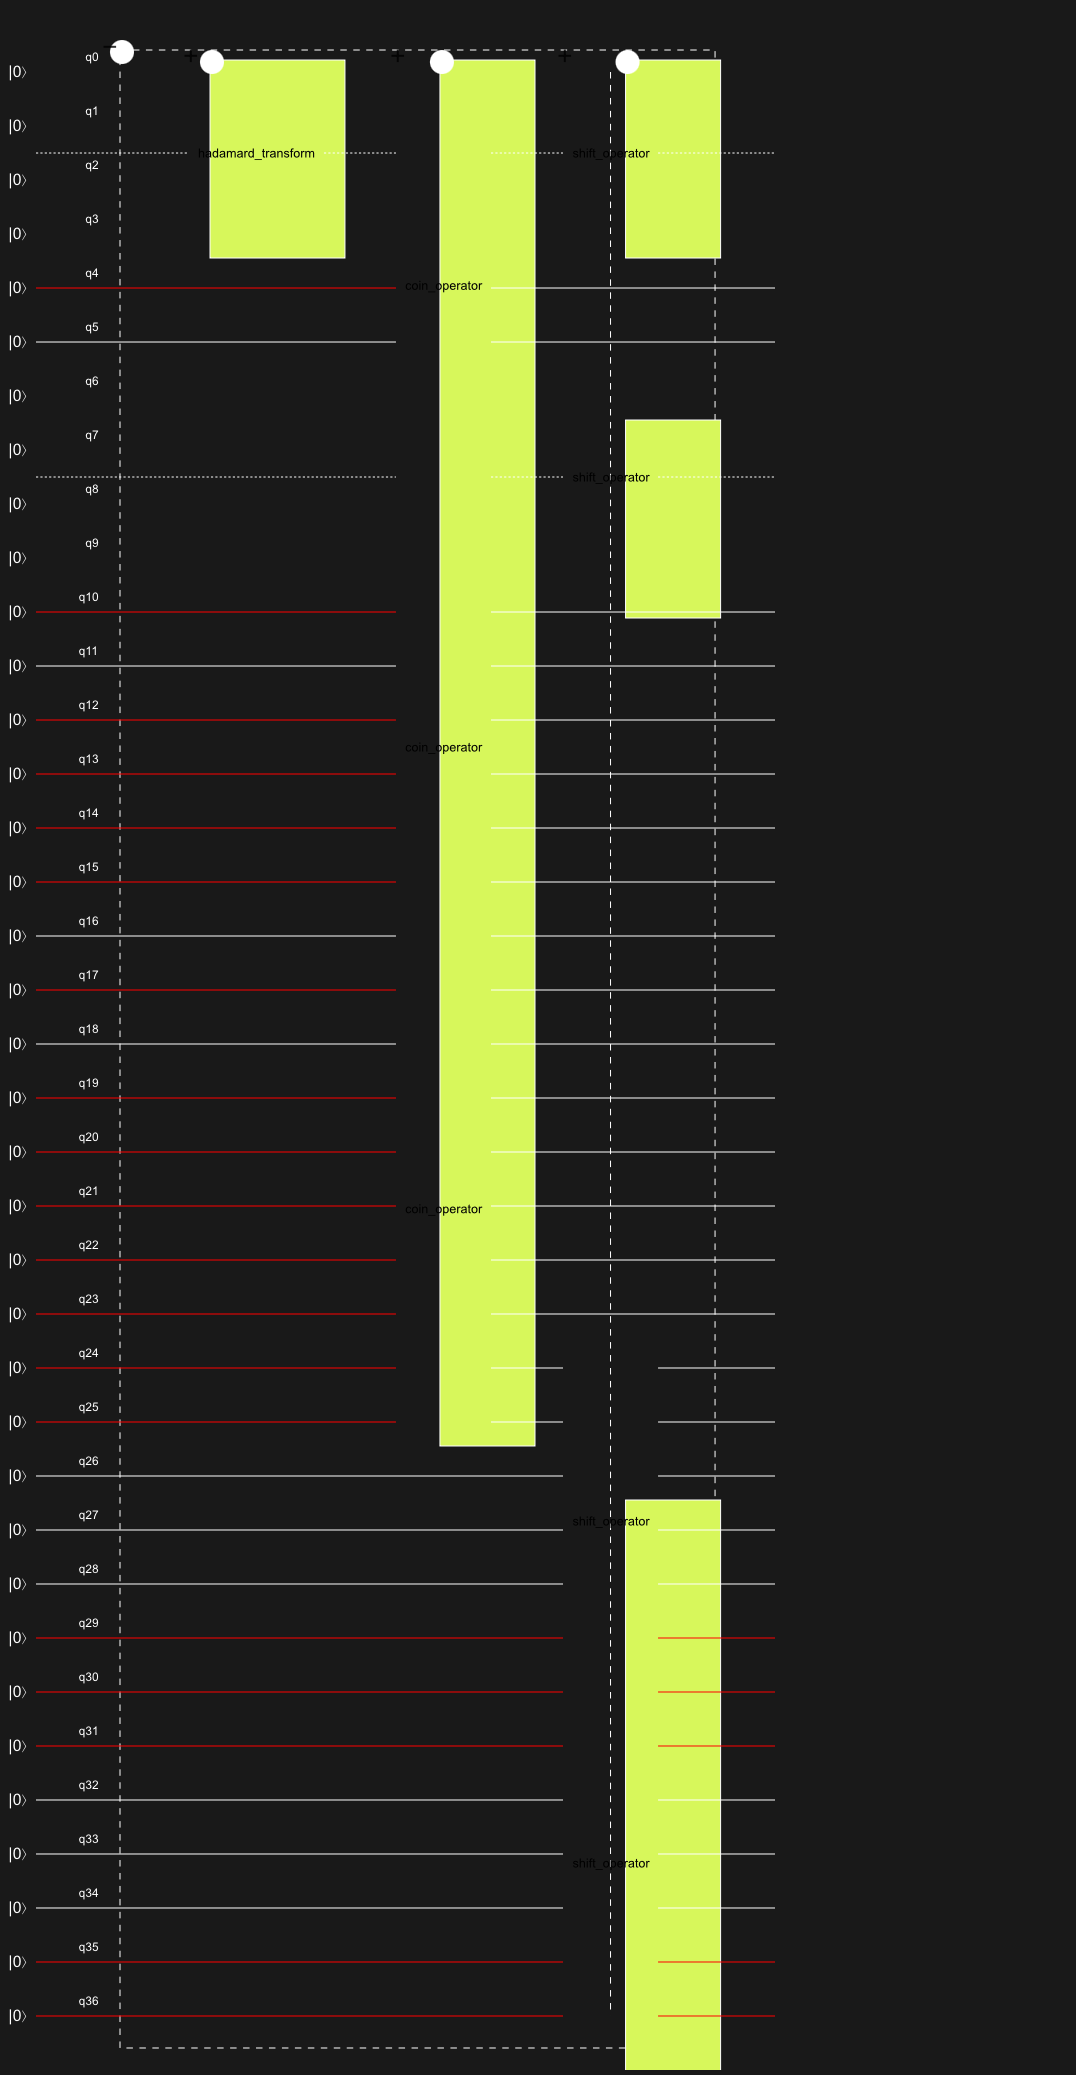

#### Steps in the circuit:

1. Hadamard Gate for equal superposition.
2. State Preparation 01 for preparing probabilities to move to adjacent vertices.
3. Diffusion Operator for proper diffusion/distribution of probabilities.
4. Edge-oracle checks if two given vertices are adjacent or not.
5. Bitwise Swap Operation swaps the states of the vertices and adjacent_vertices qubits.

## Reference:

https://arxiv.org/pdf/1001.5326

Discrete Time Quantum Walk - Dynamics and Applications by C. M. Chandrashekhar